# 02 Temporal Dynamics of AI Incidents

**Purpose**  
Analyze incident and report temporal trends using the strongest available date columns, while documenting proxy assumptions for lag analysis.

**Outputs preserved:**
- `10_incidents_per_year.png`
- `11_reports_per_year.png`
- `12_reports_monthly_rolling.png`
- `13_reporting_lag_proxy_hist.png`

## Configuration

In [17]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = next((p for p in [Path.cwd(), *Path.cwd().parents] if (p / "src").exists()), Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.notebook_utils import load_data, pick_column_by_candidates, parse_datetime_column

DATA_PATH = PROJECT_ROOT / "data"
OUTPUT_PATH = PROJECT_ROOT / "outputs" / "figures"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
TOP_N = 15
DATE_CANDIDATES = ["incident_date", "date", "incident_datetime", "incident_time"]
REPORT_DATE_CANDIDATES = ["date_published", "date_submitted", "date_modified", "date_downloaded"]
REPORT_COLUMNS = ["url", "source_domain", "date_published", "date_submitted", "date_modified", "date_downloaded"]

loaded_tables = load_data(
    DATA_PATH,
    tables=["incidents", "reports", "submissions"],
    reports_usecols=REPORT_COLUMNS,
)

incidents_df = loaded_tables["incidents"]
reports_df = loaded_tables["reports"]
submissions_df = loaded_tables["submissions"]

if incidents_df is None or reports_df is None or submissions_df is None:
    raise FileNotFoundError("Required tables missing: incidents.csv, reports.csv, or submissions.csv.")

print("Incidents:", incidents_df.shape)
print("Reports:", reports_df.shape)
print("Submissions:", submissions_df.shape)

incident_date_col = pick_column_by_candidates(incidents_df, DATE_CANDIDATES)
report_date_col = pick_column_by_candidates(reports_df, REPORT_DATE_CANDIDATES)

if incident_date_col is not None:
    incidents_df["_incident_dt"] = parse_datetime_column(incidents_df, incident_date_col)
if report_date_col is not None:
    reports_df["_report_dt"] = parse_datetime_column(reports_df, report_date_col)

print("Chosen incident date column:", incident_date_col)
print("Chosen report date column:", report_date_col)
print("Incidents with usable incident date:", 0 if incident_date_col is None else incidents_df["_incident_dt"].notna().sum())
print("Reports with usable report date:", 0 if report_date_col is None else reports_df["_report_dt"].notna().sum())

Incidents: (1367, 9)
Reports: (6687, 6)
Submissions: (45, 15)
Chosen incident date column: date
Chosen report date column: date_published
Incidents with usable incident date: 1367
Reports with usable report date: 6077


## Incident and Report Trends

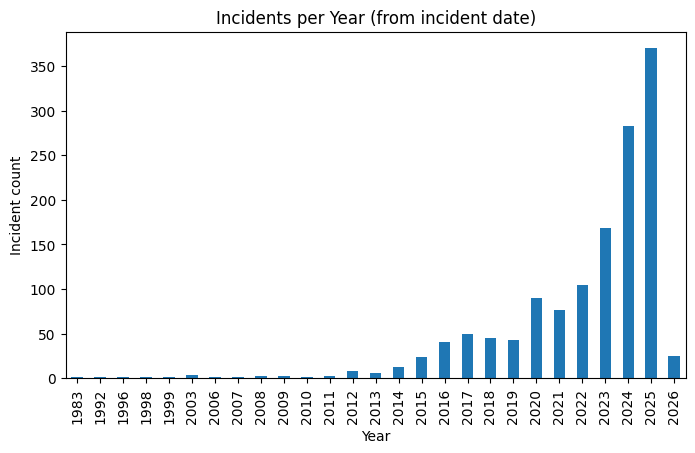

incident_year
2012      8
2013      6
2014     13
2015     24
2016     41
2017     50
2018     45
2019     43
2020     90
2021     77
2022    104
2023    168
2024    283
2025    370
2026     25
dtype: int64

In [18]:
if incident_date_col is None:
    print("No usable incident date column found in incidents.csv")
else:
    incidents_df["incident_year"] = incidents_df["_incident_dt"].dt.year
    incidents_per_year = incidents_df.dropna(subset=["incident_year"]).groupby("incident_year").size()

    fig, ax = plt.subplots(figsize=(8, 4.5))
    incidents_per_year.plot(kind="bar", ax=ax)
    ax.set_title("Incidents per Year (from incident date)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Incident count")
    fig.savefig(OUTPUT_PATH / "10_incidents_per_year.png", bbox_inches="tight", dpi=200)
    plt.show()

    display(incidents_per_year.tail(15))

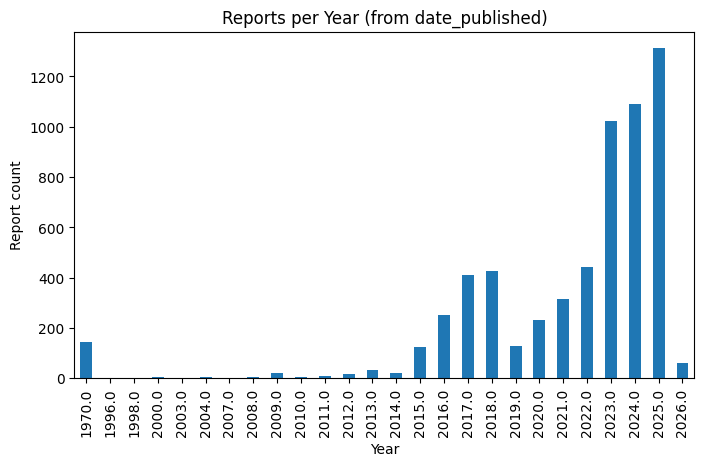

report_year
2012.0      15
2013.0      32
2014.0      22
2015.0     125
2016.0     251
2017.0     412
2018.0     427
2019.0     126
2020.0     230
2021.0     316
2022.0     442
2023.0    1023
2024.0    1092
2025.0    1313
2026.0      60
dtype: int64

In [19]:
if report_date_col is None:
    print("No usable report date column found in reports.csv")
else:
    reports_df["report_year"] = reports_df["_report_dt"].dt.year
    reports_per_year = reports_df.dropna(subset=["report_year"]).groupby("report_year").size()

    fig, ax = plt.subplots(figsize=(8, 4.5))
    reports_per_year.plot(kind="bar", ax=ax)
    ax.set_title(f"Reports per Year (from {report_date_col})")
    ax.set_xlabel("Year")
    ax.set_ylabel("Report count")
    fig.savefig(OUTPUT_PATH / "11_reports_per_year.png", bbox_inches="tight", dpi=200)
    plt.show()

    display(reports_per_year.tail(15))

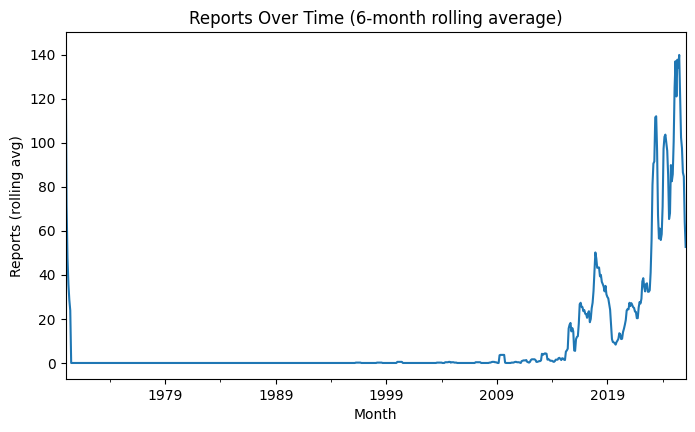

_report_dt
2024-03-31     60
2024-04-30     74
2024-05-31     89
2024-06-30     75
2024-07-31     44
2024-08-31     50
2024-09-30     76
2024-10-31    205
2024-11-30     45
2024-12-31     94
2025-01-31    133
2025-02-28    197
2025-03-31    148
2025-04-30    109
2025-05-31    145
2025-06-30     73
2025-07-31    167
2025-08-31     85
2025-09-30     35
2025-10-31     80
2025-11-30     79
2025-12-31     62
2026-01-31     43
2026-02-28     17
Freq: ME, dtype: int64

In [20]:
if report_date_col is not None:
    reports_per_month = reports_df.dropna(subset=["_report_dt"]).set_index("_report_dt").resample("ME").size()

    fig, ax = plt.subplots(figsize=(8, 4.5))
    reports_per_month.rolling(6, min_periods=1).mean().plot(ax=ax)
    ax.set_title("Reports Over Time (6-month rolling average)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Reports (rolling avg)")
    fig.savefig(OUTPUT_PATH / "12_reports_monthly_rolling.png", bbox_inches="tight", dpi=200)
    plt.show()

    display(reports_per_month.tail(24))

## Reporting Lag Proxy

Lag proxy using report date column: date_published_rep
Lag sample size (URL-merged subset): 0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64


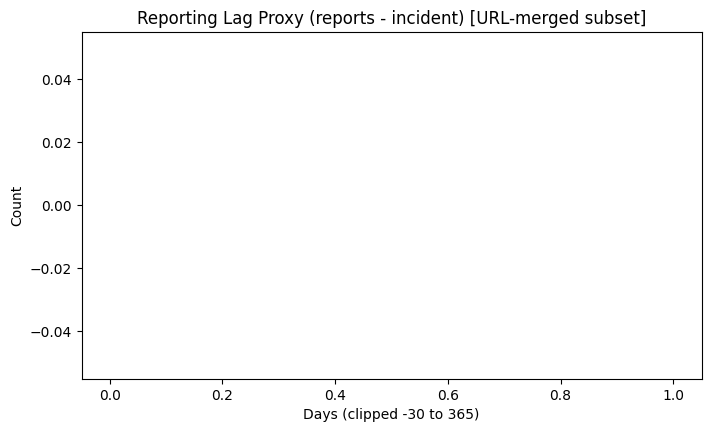

In [21]:
if "url" in submissions_df.columns and "url" in reports_df.columns:
    merged_df = submissions_df.merge(reports_df, on="url", how="inner", suffixes=("_sub", "_rep"))

    merged_df["_incident_dt"] = pd.to_datetime(merged_df.get("incident_date"), errors="coerce", utc=True).dt.tz_convert(None)

    report_date_candidates_merged = [
        "date_published_rep", "date_published",
        "date_submitted_rep", "date_submitted",
        "date_modified_rep", "date_modified",
        "date_downloaded_rep", "date_downloaded",
    ]
    lag_report_date_col = next((c for c in report_date_candidates_merged if c in merged_df.columns), None)
    print("Lag proxy using report date column:", lag_report_date_col)

    if lag_report_date_col is None:
        print("No usable report date column found after merge. Date-like columns:", [c for c in merged_df.columns if "date" in c])
    else:
        merged_df["_published_dt"] = pd.to_datetime(merged_df[lag_report_date_col], errors="coerce", utc=True).dt.tz_convert(None)
        lag_days = (merged_df["_published_dt"] - merged_df["_incident_dt"]).dt.days.dropna()

        print("Lag sample size (URL-merged subset):", len(lag_days))
        print(lag_days.describe())

        fig, ax = plt.subplots(figsize=(8, 4.5))
        lag_days.clip(lower=-30, upper=365).plot(kind="hist", bins=40, ax=ax)
        ax.set_title("Reporting Lag Proxy (reports - incident) [URL-merged subset]")
        ax.set_xlabel("Days (clipped -30 to 365)")
        ax.set_ylabel("Count")
        fig.savefig(OUTPUT_PATH / "13_reporting_lag_proxy_hist.png", bbox_inches="tight", dpi=200)
        plt.show()
else:
    print("Missing url column in submissions or reports; cannot compute lag proxy.")

## Interpretation and Limitations

- Incident and report time-series are descriptive and depend on available date quality.
- Lag is a proxy derived from the URL-merged subset, not from a complete incident-report mapping.
- Missing date columns are handled gracefully to keep notebook execution deterministic.